# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


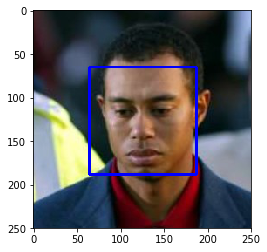

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[888])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

faces_found = [f for f in human_files_short if face_detector(f)]
face_perc = len(faces_found)
print ('Percentage of faces found in human images is {}%'.format(face_perc))

dogs_found = [d for d in dog_files_short if face_detector(d)]
dog_perc = len(dogs_found)
print ('Percentage of faces found in dog images is {}%'.format(dog_perc))

Percentage of faces found in human images is 98%
Percentage of faces found in dog images is 11%


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ No, it is too common of an occurence that pictures don't have a clear view of a face for this algorithm to be implemented without some changes to it. In order to account for this, there are various options one could take. I could create a CNN with augmented data to obtain a better recognition of the human face from different angels and profiles. Another action could be to use a different face-detecting classifier in conjunction with Haar and combine the two for a more comprehensive facial mapping.


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$


In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img)) 

In [10]:
ResNet50_predict_labels(train_files[1])

251

In [11]:
ResNet50_predict_labels('dogImages/test/041.Bullmastiff/Bullmastiff_02929.jpg')

243

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path) 
    return ((prediction <= 268) & (prediction >= 151)) 

In [14]:
dog_detector('dogImages/test/041.Bullmastiff/Bullmastiff_02929.jpg')

True

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

faces_found = len([f for f in human_files_short if dog_detector(f)])
print ('Percentage of dogs found in human images is {}%'.format(faces_found))

dogs_found = len([d for d in dog_files_short if dog_detector(d)])
print ('Percentage of dogs found in dog images is {}%'.format(dogs_found))

Percentage of dogs found in human images is 2%
Percentage of dogs found in dog images is 100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [17]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 140.19it/s]


In [18]:
print (train_tensors.shape)

(6680, 224, 224, 3)


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ For this CNN, I first chose to augment the data by rotating, shifting, flipping, and zooming the images for a larger data set to learn from, and help avoid overfitting. For the CNN structure itself, I began by implementing 3 CONV-RELU-MaxPool layers to identify lines, shapes, curves, etc. In the MaxPooling layers, I decided to use a pool-size/window that was larger than the stride of the window. This was done to avoid overfitting and reduce error rates by overlapping values. I started with a smaller number of filters with a large kernel size, and than increased the number of filters and decreased the kernel. I did this to get a better analysis of the image with more detail. I added some Dropout layers with 25-10-20% rates to reduce dimensionality. I used one more CONV-RELU layer but opted for a GAP layer to flatten the data with the best features. I added a Dropout layer, and 3 fully connected layers. The first two increased in unit size from 300-600, and the final layer had a unit size of 133 for the number of dog breeds. The CNN ended with just shy of 430,000 parameters which is not very much, and if I want to return to this project to optimize this CNN, I would implement a hyperparameter search for optimized results.

In [19]:
from keras.preprocessing.image import ImageDataGenerator

augdata = ImageDataGenerator(rotation_range=25,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             vertical_flip=True,
                             horizontal_flip=True,
                             zoom_range=0.2)

augdata.fit(train_tensors)

In [20]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
### TODO: Define your architecture.
model.add(Conv2D(filters=25,kernel_size=6,activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=4,strides=3,padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(75,4,activation='relu'))
model.add(MaxPooling2D(3,2,padding='same'))
model.add(Dropout(0.1))

model.add(Conv2D(50,5,activation='relu'))
model.add(MaxPooling2D(4,4,padding='same'))
model.add(Conv2D(20,6,activation='relu'))
model.add(GlobalAveragePooling2D())

model.add(Dropout(0.2))
model.add(Dense(300,activation='relu'))
model.add(Dense(600,activation='relu'))
model.add(Dense(133,activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 219, 219, 25)      2725      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 25)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 73, 25)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 70, 75)        30075     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 75)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 35, 35, 75)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 50)        93800     
__________

### Compile the Model

In [21]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [26]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10
batch_size = 50

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit_generator(augdata.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets),
                    steps_per_epoch=train_tensors.shape[0] // batch_size, 
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/10
133/133 [==============================] - 53s - loss: 4.8853 - acc: 0.0080 - val_loss: 4.8718 - val_acc: 0.0120
Epoch 2/10
133/133 [==============================] - 50s - loss: 4.8138 - acc: 0.0144 - val_loss: 4.7446 - val_acc: 0.0216
Epoch 3/10
133/133 [==============================] - 51s - loss: 4.7125 - acc: 0.0171 - val_loss: 4.7497 - val_acc: 0.0192
Epoch 4/10
133/133 [==============================] - 50s - loss: 4.6733 - acc: 0.0215 - val_loss: 4.6167 - val_acc: 0.0263
Epoch 5/10
133/133 [==============================] - 50s - loss: 4.6046 - acc: 0.0227 - val_loss: 4.6655 - val_acc: 0.0228
Epoch 6/10
133/133 [==============================] - 50s - loss: 4.5342 - acc: 0.0330 - val_loss: 4.4567 - val_acc: 0.0371
Epoch 7/10
133/133 [==============================] - 50s - loss: 4.4488 - acc: 0.0419 - val_loss: 4.3252 - val_acc: 0.0359
Epoch 8/10
133/133 [==============================] - 51s - loss: 4.3619 - acc: 0.0456 - val_loss: 4.1857 - val_acc: 0.0551
Epoch 9/

### Load the Model with the Best Validation Loss

In [27]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [28]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 6.1005%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [22]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [23]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(1020, activation='relu'))
VGG16_model.add(Dropout(0.3))
VGG16_model.add(Dense(500, activation='relu'))
VGG16_model.add(Dropout(0.1))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1020)              523260    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1020)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               510500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               66633     
Total params: 1,100,393.0
Trainable params: 1,100,393.0
Non-trainable params: 0.0
____________________________________________________________

### Compile the Model

In [24]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [29]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=75, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/75
6680/6680 [==============================] - 2s - loss: 4.2012 - acc: 0.3178 - val_loss: 1.5441 - val_acc: 0.5760
Epoch 2/75
6680/6680 [==============================] - 2s - loss: 1.5421 - acc: 0.5952 - val_loss: 1.1300 - val_acc: 0.6743
Epoch 3/75
6680/6680 [==============================] - 2s - loss: 1.2422 - acc: 0.6751 - val_loss: 1.3576 - val_acc: 0.6539
Epoch 4/75
6680/6680 [==============================] - 2s - loss: 1.0443 - acc: 0.7325 - val_loss: 1.1208 - val_acc: 0.7126
Epoch 5/75
6680/6680 [==============================] - 2s - loss: 0.9940 - acc: 0.7479 - val_loss: 1.1757 - val_acc: 0.7078
Epoch 6/75
6680/6680 [==============================] - 2s - loss: 0.9567 - acc: 0.7654 - val_loss: 1.2328 - val_acc: 0.7138
Epoch 7/75
6680/6680 [==============================] - 2s - loss: 0.8880 - acc: 0.7888 - val_loss: 1.1703 - val_acc: 0.7437
Epoch 8/75
6680/6680 [==============================] - 2s - loss: 0.8679 - ac

6680/6680 [==============================] - 2s - loss: 1.0108 - acc: 0.8963 - val_loss: 2.9266 - val_acc: 0.7533
Epoch 34/75
6680/6680 [==============================] - 2s - loss: 0.9230 - acc: 0.9040 - val_loss: 2.7535 - val_acc: 0.7772
Epoch 35/75
6680/6680 [==============================] - 2s - loss: 1.0004 - acc: 0.9033 - val_loss: 3.0524 - val_acc: 0.7665
Epoch 36/75
6680/6680 [==============================] - 2s - loss: 1.0896 - acc: 0.8969 - val_loss: 3.0198 - val_acc: 0.7593
Epoch 37/75
6680/6680 [==============================] - 2s - loss: 1.0808 - acc: 0.8993 - val_loss: 2.9890 - val_acc: 0.7581
Epoch 38/75
6680/6680 [==============================] - 2s - loss: 1.2475 - acc: 0.8880 - val_loss: 2.7983 - val_acc: 0.7784
Epoch 39/75
6680/6680 [==============================] - 2s - loss: 1.2093 - acc: 0.8927 - val_loss: 2.9183 - val_acc: 0.7701
Epoch 40/75
6680/6680 [==============================] - 2s - loss: 1.2528 - acc: 0.8952 - val_loss: 2.9769 - val_acc: 0.7689
Epoc

### Load the Model with the Best Validation Loss

In [30]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [31]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 70.3349%


### Predict Dog Breed with the Model

In [34]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [58]:
VGG16_predict_breed('dogImages/test/016.Beagle/Beagle_01141.jpg')

'Beagle'

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

## ResNet50 Model

In [31]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']

#print ('ResNet-50 shape =',train_ResNet50.shape)
#print ('ResNet-50 shape =',train_ResNet50.shape[1:])

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ For my final CNN structure, I decided to test the InceptionV3, ResNet50, VGG16, and VGG19 models transfered in. After transferring the models and testing the accuracy of each, I found that the Inception, ResNet, and VGG16 were the three best. I elected to move forward with the Inception and VGG models for testing my images. The Inception and ResNet models were nearly identical in accuracy, I then tried to add additional fully-connected layers to the models to increase accuracy, but it only hurt the overall score. I therefore resorted to using the model transfered with a GAP and single Dense layer. I did play around with the optimizer for the Inception model. I tested the model using "Adam", "Adamax", "SGD", "RMSprop", and "Adagrad". I settled on "Adamax" as my optimizer, as it gave me the highest test accuracy.

In [32]:
### TODO: Define your architecture.

ResNet50_model = Sequential()
ResNet50_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:])) #train_ResNet50.shape[1:]
ResNet50_model.add(Dense(133, activation='softmax'))

ResNet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [33]:
### TODO: Compile the model.

ResNet50_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [34]:
### AUGMENT DATA :
#from keras.preprocessing.image import ImageDataGenerator
'''
augdata = ImageDataGenerator(rotation_range=25,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             vertical_flip=True,
                             horizontal_flip=True,
                             zoom_range=0.2)

augdata.fit(train_ResNet50)

### TODO: Train the model.

epochs = 100
batch_size = 30
'''
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

ResNet50_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=200, batch_size=35, callbacks=[checkpointer], verbose=1)

'''
ResNet50_model.fit_generator(augdata.flow(train_ResNet50, train_targets, batch_size=batch_size), 
                             validation_data=(valid_ResNet50, valid_targets), 
                             steps_per_epoch=train_ResNet50.shape[0] // batch_size, 
                             epochs=epochs, callbacks=[checkpointer], verbose=1)
'''

Train on 6680 samples, validate on 835 samples
Epoch 1/200
6680/6680 [==============================] - 1s - loss: 3.6648 - acc: 0.2629 - val_loss: 2.4427 - val_acc: 0.5198
Epoch 2/200
6680/6680 [==============================] - 0s - loss: 1.8083 - acc: 0.6493 - val_loss: 1.5425 - val_acc: 0.6994
Epoch 3/200
6680/6680 [==============================] - 0s - loss: 1.1907 - acc: 0.7683 - val_loss: 1.2063 - val_acc: 0.7317
Epoch 4/200
6680/6680 [==============================] - 0s - loss: 0.9134 - acc: 0.8238 - val_loss: 1.0208 - val_acc: 0.7760
Epoch 5/200
6680/6680 [==============================] - 0s - loss: 0.7502 - acc: 0.8539 - val_loss: 0.9178 - val_acc: 0.7808
Epoch 6/200
6680/6680 [==============================] - 0s - loss: 0.6429 - acc: 0.8787 - val_loss: 0.8434 - val_acc: 0.8000
Epoch 7/200
6680/6680 [==============================] - 0s - loss: 0.5661 - acc: 0.8943 - val_loss: 0.7923 - val_acc: 0.8036
Epoch 8/200
6680/6680 [==============================] - 0s - loss: 0.5

6680/6680 [==============================] - 0s - loss: 0.1781 - acc: 0.9849 - val_loss: 0.5688 - val_acc: 0.8323
Epoch 27/200
6680/6680 [==============================] - 0s - loss: 0.1718 - acc: 0.9864 - val_loss: 0.5697 - val_acc: 0.8275
Epoch 28/200
6680/6680 [==============================] - 0s - loss: 0.1655 - acc: 0.9855 - val_loss: 0.5659 - val_acc: 0.8323
Epoch 29/200
6680/6680 [==============================] - 0s - loss: 0.1600 - acc: 0.9880 - val_loss: 0.5631 - val_acc: 0.8347
Epoch 30/200
6680/6680 [==============================] - 0s - loss: 0.1548 - acc: 0.9888 - val_loss: 0.5613 - val_acc: 0.8383
Epoch 31/200
6680/6680 [==============================] - 0s - loss: 0.1495 - acc: 0.9894 - val_loss: 0.5595 - val_acc: 0.8335
Epoch 32/200
6680/6680 [==============================] - 0s - loss: 0.1449 - acc: 0.9903 - val_loss: 0.5560 - val_acc: 0.8359
Epoch 33/200
6680/6680 [==============================] - 0s - loss: 0.1405 - acc: 0.9915 - val_loss: 0.5534 - val_acc: 0.83

6680/6680 [==============================] - 0s - loss: 0.0555 - acc: 0.9988 - val_loss: 0.5214 - val_acc: 0.8395
Epoch 82/200
6680/6680 [==============================] - 0s - loss: 0.0548 - acc: 0.9990 - val_loss: 0.5217 - val_acc: 0.8359
Epoch 83/200
6680/6680 [==============================] - 0s - loss: 0.0542 - acc: 0.9985 - val_loss: 0.5213 - val_acc: 0.8323
Epoch 84/200
6680/6680 [==============================] - 0s - loss: 0.0535 - acc: 0.9988 - val_loss: 0.5211 - val_acc: 0.8371
Epoch 85/200
6680/6680 [==============================] - 0s - loss: 0.0528 - acc: 0.9987 - val_loss: 0.5209 - val_acc: 0.8347
Epoch 86/200
6680/6680 [==============================] - 0s - loss: 0.0522 - acc: 0.9991 - val_loss: 0.5210 - val_acc: 0.8383
Epoch 87/200
6680/6680 [==============================] - 0s - loss: 0.0516 - acc: 0.9988 - val_loss: 0.5213 - val_acc: 0.8347
Epoch 88/200
6680/6680 [==============================] - 0s - loss: 0.0510 - acc: 0.9991 - val_loss: 0.5208 - val_acc: 0.83

6680/6680 [==============================] - 0s - loss: 0.0314 - acc: 0.9991 - val_loss: 0.5198 - val_acc: 0.8371
Epoch 144/200
6680/6680 [==============================] - 0s - loss: 0.0312 - acc: 0.9990 - val_loss: 0.5195 - val_acc: 0.8395
Epoch 145/200
6680/6680 [==============================] - 0s - loss: 0.0309 - acc: 0.9988 - val_loss: 0.5197 - val_acc: 0.8383
Epoch 146/200
6680/6680 [==============================] - 0s - loss: 0.0307 - acc: 0.9987 - val_loss: 0.5193 - val_acc: 0.8371
Epoch 147/200
6680/6680 [==============================] - 0s - loss: 0.0305 - acc: 0.9988 - val_loss: 0.5199 - val_acc: 0.8359
Epoch 148/200
6680/6680 [==============================] - 0s - loss: 0.0303 - acc: 0.9991 - val_loss: 0.5194 - val_acc: 0.8371
Epoch 149/200
6680/6680 [==============================] - 0s - loss: 0.0301 - acc: 0.9990 - val_loss: 0.5203 - val_acc: 0.8383
Epoch 150/200
6680/6680 [==============================] - 0s - loss: 0.0299 - acc: 0.9990 - val_loss: 0.5201 - val_ac

'\nResNet50_model.fit_generator(augdata.flow(train_ResNet50, train_targets, batch_size=batch_size), \n                             validation_data=(valid_ResNet50, valid_targets), \n                             steps_per_epoch=train_ResNet50.shape[0] // batch_size, \n                             epochs=epochs, callbacks=[checkpointer], verbose=1)\n'

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [35]:
### TODO: Load the model weights with the best validation loss.
ResNet50_model.load_weights('saved_models/weights.best.ResNet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [36]:
### TODO: Calculate classification accuracy on the test dataset.
ResNet50_predictions = [np.argmax(ResNet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('ResNet50 test accuracy: %.4f%%' % test_accuracy)

ResNet50 test accuracy: 83.2536%


## InceptionV3 Model

In [51]:
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_Incep = bottleneck_features['train']
valid_Incep = bottleneck_features['valid']
test_Incep = bottleneck_features['test']

Incep_model = Sequential()
Incep_model.add(GlobalAveragePooling2D(input_shape=train_Incep.shape[1:]))
Incep_model.add(Dense(133, activation='softmax'))

Incep_model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Incep.hdf5', 
                               verbose=1, save_best_only=True)

Incep_model.fit(train_Incep, train_targets, 
          validation_data=(valid_Incep, valid_targets),
          epochs=200, batch_size=30, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/200
6680/6680 [==============================] - 2s - loss: 1.3595 - acc: 0.6877 - val_loss: 0.6216 - val_acc: 0.8168
Epoch 2/200
6680/6680 [==============================] - 1s - loss: 0.4524 - acc: 0.8639 - val_loss: 0.5332 - val_acc: 0.8371
Epoch 3/200
6680/6680 [==============================] - 1s - loss: 0.3379 - acc: 0.9025 - val_loss: 0.5033 - val_acc: 0.8479
Epoch 4/200
6680/6680 [==============================] - 1s - loss: 0.2641 - acc: 0.9283 - val_loss: 0.5003 - val_acc: 0.8575
Epoch 5/200
6680/6680 [==============================] - 1s - loss: 0.2121 - acc: 0.9467 - val_loss: 0.4916 - val_acc: 0.8611
Epoch 6/200
6680/6680 [==============================] - 1s - loss: 0.1778 - acc: 0.9542 - val_loss: 0.4917 - val_acc: 0.8551
Epoch 7/200
6680/6680 [==============================] - 1s - loss: 0.1433 - acc: 0.9675 - val_loss: 0.4910 - val_acc: 0.8611
Epoch 8/200
6680/6680 [==============================] - 1s - loss: 0.1

6680/6680 [==============================] - 1s - loss: 0.0025 - acc: 0.9991 - val_loss: 0.8270 - val_acc: 0.8563
Epoch 66/200
6680/6680 [==============================] - 1s - loss: 0.0027 - acc: 0.9990 - val_loss: 0.8146 - val_acc: 0.8611
Epoch 67/200
6680/6680 [==============================] - 1s - loss: 0.0023 - acc: 0.9991 - val_loss: 0.8290 - val_acc: 0.8623
Epoch 68/200
6680/6680 [==============================] - 1s - loss: 0.0027 - acc: 0.9990 - val_loss: 0.8309 - val_acc: 0.8635
Epoch 69/200
6680/6680 [==============================] - 1s - loss: 0.0026 - acc: 0.9990 - val_loss: 0.8454 - val_acc: 0.8671
Epoch 70/200
6680/6680 [==============================] - 1s - loss: 0.0028 - acc: 0.9987 - val_loss: 0.8388 - val_acc: 0.8659
Epoch 71/200
6680/6680 [==============================] - 1s - loss: 0.0024 - acc: 0.9991 - val_loss: 0.8484 - val_acc: 0.8623
Epoch 72/200
6680/6680 [==============================] - 1s - loss: 0.0026 - acc: 0.9988 - val_loss: 0.8486 - val_acc: 0.86

6680/6680 [==============================] - 1s - loss: 0.0025 - acc: 0.9987 - val_loss: 1.1065 - val_acc: 0.8587
Epoch 132/200
6680/6680 [==============================] - 1s - loss: 0.0020 - acc: 0.9991 - val_loss: 1.1086 - val_acc: 0.8563
Epoch 133/200
6680/6680 [==============================] - 1s - loss: 0.0022 - acc: 0.9991 - val_loss: 1.0893 - val_acc: 0.8563
Epoch 134/200
6680/6680 [==============================] - 1s - loss: 0.0022 - acc: 0.9990 - val_loss: 1.0960 - val_acc: 0.8575
Epoch 135/200
6680/6680 [==============================] - 1s - loss: 0.0022 - acc: 0.9990 - val_loss: 1.1062 - val_acc: 0.8527
Epoch 136/200
6680/6680 [==============================] - 1s - loss: 0.0024 - acc: 0.9988 - val_loss: 1.1009 - val_acc: 0.8563
Epoch 137/200
6680/6680 [==============================] - 1s - loss: 0.0022 - acc: 0.9990 - val_loss: 1.1158 - val_acc: 0.8575
Epoch 138/200
6680/6680 [==============================] - 1s - loss: 0.0021 - acc: 0.9987 - val_loss: 1.1134 - val_ac

6680/6680 [==============================] - 1s - loss: 0.0022 - acc: 0.9990 - val_loss: 1.1994 - val_acc: 0.8503
Epoch 198/200
6680/6680 [==============================] - 1s - loss: 0.0021 - acc: 0.9987 - val_loss: 1.2065 - val_acc: 0.8515
Epoch 199/200
6680/6680 [==============================] - 1s - loss: 0.0021 - acc: 0.9990 - val_loss: 1.2044 - val_acc: 0.8503
Epoch 200/200
6680/6680 [==============================] - 1s - loss: 0.0024 - acc: 0.9988 - val_loss: 1.1995 - val_acc: 0.8503


In [38]:
Incep_model.load_weights('saved_models/weights.best.Incep.hdf5')

Incep_predictions = [np.argmax(Incep_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Incep]

test_accuracy = 100*np.sum(np.array(Incep_predictions)==np.argmax(test_targets, axis=1))/len(Incep_predictions)
print('InceptionV3 test accuracy: %.4f%%' % test_accuracy)

InceptionV3 test accuracy: 83.4928%


In [52]:
def Incep_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Incep_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    breed = dog_names[np.argmax(predicted_vector)]
    return breed

In [40]:
Incep_predict_breed('dogImages/test/016.Beagle/Beagle_01141.jpg')

'Beagle'

## VGG19 Model

In [41]:
bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
train_VGG19 = bottleneck_features['train']
valid_VGG19 = bottleneck_features['valid']
test_VGG19 = bottleneck_features['test']

VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
VGG16_model.add(Dense(1020, activation='relu'))
VGG16_model.add(Dropout(0.3))
VGG16_model.add(Dense(500, activation='relu'))
VGG16_model.add(Dropout(0.1))
VGG19_model.add(Dense(133, activation='softmax'))

VGG19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


In [42]:
VGG19_model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

VGG19_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=200, batch_size=30, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/200
6680/6680 [==============================] - 2s - loss: 12.3204 - acc: 0.0807 - val_loss: 10.5068 - val_acc: 0.1689
Epoch 2/200
6680/6680 [==============================] - 1s - loss: 9.4445 - acc: 0.2347 - val_loss: 9.0237 - val_acc: 0.2587
Epoch 3/200
6680/6680 [==============================] - 1s - loss: 8.1775 - acc: 0.3307 - val_loss: 8.1290 - val_acc: 0.3090
Epoch 4/200
6680/6680 [==============================] - 1s - loss: 7.3393 - acc: 0.3999 - val_loss: 7.5312 - val_acc: 0.3533
Epoch 5/200
6680/6680 [==============================] - 1s - loss: 6.6076 - acc: 0.4573 - val_loss: 6.9951 - val_acc: 0.3796
Epoch 6/200
6680/6680 [==============================] - 1s - loss: 6.1598 - acc: 0.5060 - val_loss: 6.7106 - val_acc: 0.4012
Epoch 7/200
6680/6680 [==============================] - 1s - loss: 5.9045 - acc: 0.5473 - val_loss: 6.5392 - val_acc: 0.4311
Epoch 8/200
6680/6680 [==============================] - 1s - loss: 5

6680/6680 [==============================] - 1s - loss: 5.3401 - acc: 0.6680 - val_loss: 6.0938 - val_acc: 0.5497
Epoch 61/200
6680/6680 [==============================] - 1s - loss: 5.3396 - acc: 0.6681 - val_loss: 6.0806 - val_acc: 0.5509
Epoch 62/200
6680/6680 [==============================] - 1s - loss: 5.3407 - acc: 0.6678 - val_loss: 6.1069 - val_acc: 0.5485
Epoch 63/200
6680/6680 [==============================] - 1s - loss: 5.3398 - acc: 0.6680 - val_loss: 6.0818 - val_acc: 0.5509
Epoch 64/200
6680/6680 [==============================] - 1s - loss: 5.3397 - acc: 0.6681 - val_loss: 6.0801 - val_acc: 0.5473
Epoch 65/200
6680/6680 [==============================] - 1s - loss: 5.3408 - acc: 0.6678 - val_loss: 6.0891 - val_acc: 0.5485
Epoch 66/200
6680/6680 [==============================] - 1s - loss: 5.3406 - acc: 0.6678 - val_loss: 6.0828 - val_acc: 0.5521
Epoch 67/200
6680/6680 [==============================] - 1s - loss: 5.3407 - acc: 0.6678 - val_loss: 6.1223 - val_acc: 0.54

6680/6680 [==============================] - 1s - loss: 5.3401 - acc: 0.6680 - val_loss: 6.2339 - val_acc: 0.5533
Epoch 127/200
6680/6680 [==============================] - 1s - loss: 5.3405 - acc: 0.6680 - val_loss: 6.2352 - val_acc: 0.5509
Epoch 128/200
6680/6680 [==============================] - 1s - loss: 5.3404 - acc: 0.6680 - val_loss: 6.2256 - val_acc: 0.5569
Epoch 129/200
6680/6680 [==============================] - 1s - loss: 5.3405 - acc: 0.6680 - val_loss: 6.2135 - val_acc: 0.5533
Epoch 130/200
6680/6680 [==============================] - 1s - loss: 5.3399 - acc: 0.6681 - val_loss: 6.2732 - val_acc: 0.5485
Epoch 131/200
6680/6680 [==============================] - 1s - loss: 5.3403 - acc: 0.6680 - val_loss: 6.2244 - val_acc: 0.5485
Epoch 132/200
6680/6680 [==============================] - 1s - loss: 5.3405 - acc: 0.6680 - val_loss: 6.2213 - val_acc: 0.5521
Epoch 133/200
6680/6680 [==============================] - 1s - loss: 5.3404 - acc: 0.6681 - val_loss: 6.2468 - val_ac

6680/6680 [==============================] - 1s - loss: 5.3402 - acc: 0.6681 - val_loss: 6.2496 - val_acc: 0.5497
Epoch 193/200
6680/6680 [==============================] - 1s - loss: 5.3397 - acc: 0.6681 - val_loss: 6.2491 - val_acc: 0.5449
Epoch 194/200
6680/6680 [==============================] - 1s - loss: 5.3406 - acc: 0.6678 - val_loss: 6.2695 - val_acc: 0.5425
Epoch 195/200
6680/6680 [==============================] - 1s - loss: 5.3412 - acc: 0.6677 - val_loss: 6.2307 - val_acc: 0.5485
Epoch 196/200
6680/6680 [==============================] - 1s - loss: 5.3394 - acc: 0.6683 - val_loss: 6.2778 - val_acc: 0.5497
Epoch 197/200
6680/6680 [==============================] - 1s - loss: 5.3396 - acc: 0.6683 - val_loss: 6.2475 - val_acc: 0.5497
Epoch 198/200
6680/6680 [==============================] - 1s - loss: 5.3400 - acc: 0.6681 - val_loss: 6.2467 - val_acc: 0.5473
Epoch 199/200
6680/6680 [==============================] - 1s - loss: 5.3393 - acc: 0.6683 - val_loss: 6.2523 - val_ac

In [43]:
VGG19_model.load_weights('saved_models/weights.best.VGG19.hdf5')

VGG19_predictions = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]

test_accuracy = 100*np.sum(np.array(VGG19_predictions)==np.argmax(test_targets, axis=1))/len(VGG19_predictions)
print('VGG19 test accuracy: %.4f%%' % test_accuracy)

VGG19 test accuracy: 52.5120%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [44]:
print (train_VGG16.shape[1:]) #works
print (train_VGG19.shape[1:]) #works
print (train_ResNet50.shape[1:])
print (train_Incep.shape[1:])

(7, 7, 512)
(7, 7, 512)
(1, 1, 2048)
(5, 5, 2048)


In [45]:
def VGG19_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG19(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG19_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [50]:
VGG19_predict_breed('dogImages/test/016.Beagle/Beagle_01141.jpg')

'Welsh_springer_spaniel'

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [53]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def extract_InceptionV3(tensor):
	from keras.applications.inception_v3 import InceptionV3, preprocess_input
	return InceptionV3(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def extract_Resnet50(tensor):
	from keras.applications.resnet50 import ResNet50, preprocess_input
	return ResNet50(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

#from extract_bottleneck_features import *

def Incep_predict_breed(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
        
    if dog_detector(img_path) == True:
        # load chosen model and predict dog breed
        bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
        predicted_vector = Incep_model.predict(bottleneck_feature)
        breed = dog_names[np.argmax(predicted_vector)]
        # print output with the specific dog breed
        print ('This dog is a {}'.format(breed))
    elif face_detector(img_path) == True:
        # load chosen model and predict dog breed
        bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
        predicted_vector = Incep_model.predict(bottleneck_feature)
        breed = dog_names[np.argmax(predicted_vector)]
        # print output with the specific dog breed
        print ('This human most looks like a {}'.format(breed))
    else:
        print ('Could not find a dog or human in this photo')

def ResNet50_predict_breed(img_path):
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path)) #extracts ResNet50 bottleneck features
    predicted_vector = ResNet50_model.predict(bottleneck_feature) #finds vector of predicitons from images
    breed = dog_names[np.argmax(predicted_vector)] #returns the name of the predicted dog breed
    
    if dog_detector(img_path) == True:
        print ('This dog is a {}'.format(breed))
    else:
        print ('If this was a dog, it would be a {}'.format(breed))
        
def VGG16_predict_breed(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
        
    if dog_detector(img_path) == True:
        # load chosen model and predict dog breed
        bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
        predicted_vector = VGG16_model.predict(bottleneck_feature)
        breed = dog_names[np.argmax(predicted_vector)]
        # print output with the specific dog breed
        print ('This dog is a {}'.format(breed))
    elif face_detector(img_path) == True:
        # load chosen model and predict dog breed
        bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
        predicted_vector = VGG16_model.predict(bottleneck_feature)
        breed = dog_names[np.argmax(predicted_vector)]
        # print output with the specific dog breed
        print ('This human most looks like a {}'.format(breed))
    else:
        print ('Could not find a dog or human in this photo')

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

--------------------------------------------------------------------------------------------------------------------------------

__Answer:__ 

I tested two different models with the same 8 images. Images 2 and 6 were people, therefore I will exclude them from my analysis. For the remaining 6 images of dogs, only image 5 and image 8 produced the same output for both models tested. The remaining 4 images all produced different outputs in relation to their counterpart. I would believe that the InceptionV3 model would be the more accurate of the two models ran, which it is. It predicted the correct breed 3 of the 4 times. The VGG16 model produced the correct output for image 4 alone.

Some possible improvements:
1. I might choose in the future to implement a hyper-parameter grid search to improve the model to its max potential without overfitting. Some parameters could be optimizer, learning rate, epochs, batch_size, etc.
2. Adding augmented data into the models would help with overfitting and ability to read the images effectively.
3. Another possible improvement could be to add more layers to the models to increase accuracy, but it's important to keep in mind that too many layers will inevitably lead to a decrease in overall accuracy.

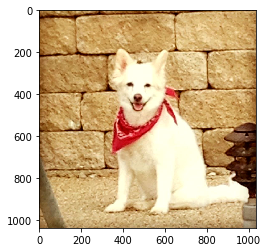

This dog is a Canaan_dog


In [41]:
VGG16_predict_breed('dogImages/personal/pic1.jpg')

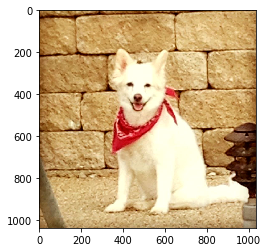

This dog is a Akita


In [54]:
Incep_predict_breed('dogImages/personal/pic1.jpg')

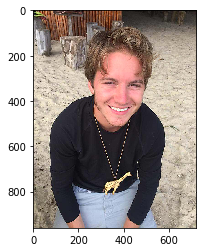

This human most looks like a Kerry_blue_terrier


In [42]:
VGG16_predict_breed('dogImages/personal/pic2.jpg')

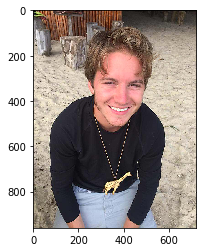

This human most looks like a Doberman_pinscher


In [55]:
Incep_predict_breed('dogImages/personal/pic2.jpg')

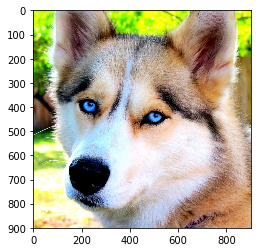

This dog is a Norwegian_buhund


In [43]:
VGG16_predict_breed('dogImages/personal/pic3.jpg')

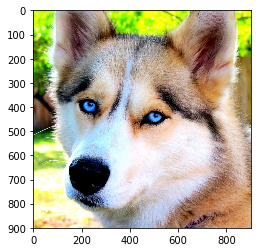

This dog is a Alaskan_malamute


In [56]:
Incep_predict_breed('dogImages/personal/pic3.jpg')

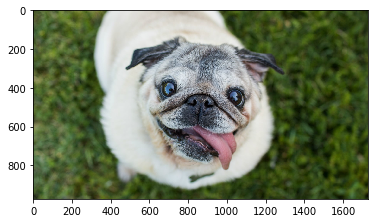

This dog is a Bulldog


In [44]:
VGG16_predict_breed('dogImages/personal/pic4.jpg')

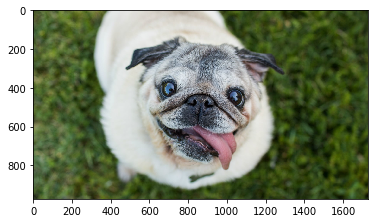

This dog is a Lhasa_apso


In [62]:
Incep_predict_breed('dogImages/personal/pic4.jpg')

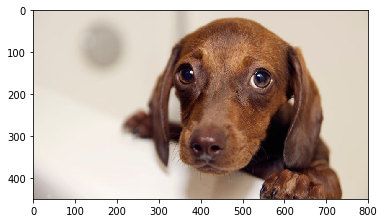

This dog is a Dachshund


In [45]:
VGG16_predict_breed('dogImages/personal/pic5.jpg')

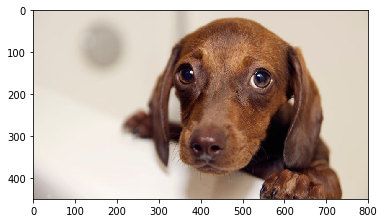

This dog is a Dachshund


In [58]:
Incep_predict_breed('dogImages/personal/pic5.jpg')

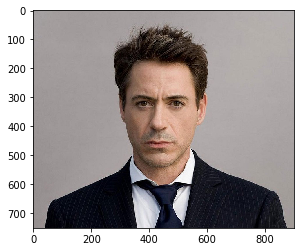

This human most looks like a Pomeranian


In [46]:
VGG16_predict_breed('dogImages/personal/pic6.jpg')

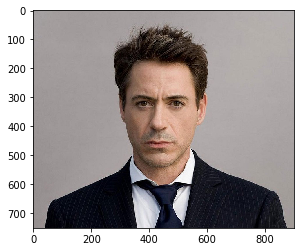

This human most looks like a Dachshund


In [59]:
Incep_predict_breed('dogImages/personal/pic6.jpg')

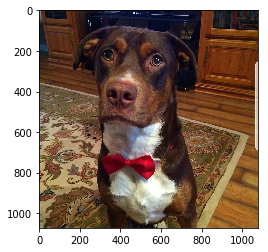

This dog is a American_staffordshire_terrier


In [47]:
VGG16_predict_breed('dogImages/personal/pic7.jpg')

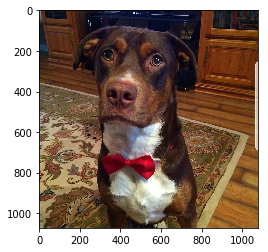

This dog is a Pointer


In [60]:
Incep_predict_breed('dogImages/personal/pic7.jpg')

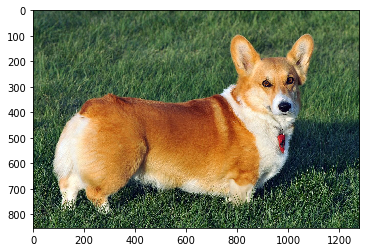

This dog is a Pembroke_welsh_corgi


In [65]:
VGG16_predict_breed('dogImages/personal/pic10.jpg')

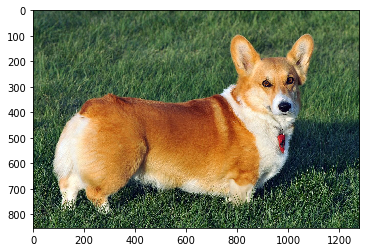

This dog is a Pembroke_welsh_corgi


In [66]:
Incep_predict_breed('dogImages/personal/pic10.jpg')